<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

### **5.1. Import Libraries and Modules**

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### **5.2. Import and Divide Dataset**

Flotation plant product Iron and Silica concentrates namely the last two columns. We will develop separate models for silica and iron in machine learning, so we will separate the columns from the main data as two data types named "iron_concentrate" and "silica_concentrate". The remaining columns are essentially flotation conditions required to enrich the concentrate. We also separate them as "flotation_conditions".

In [172]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/
flotation = pd.read_csv('Flotation_Plant_Grouped.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [173]:
flotation_conditions = flotation.iloc[:,1:22]
concentrates = flotation.iloc[:,22:]
iron_concentrate = concentrates.iloc[:,0].values
silica_concentrate = concentrates.iloc[:,1].values

print('Shape of flotation_conditions = ', flotation_conditions.shape)
print('Shape of iron_concentrate = ', iron_concentrate.shape)
print('Shape of silica_concentrate = ', silica_concentrate.shape);

Shape of flotation_conditions =  (4097, 21)
Shape of iron_concentrate =  (4097,)
Shape of silica_concentrate =  (4097,)



## **6. P-Value and Confidence Interval**

### **6.1. P-Value**

In [174]:
b_zero = np.append(arr = np.ones((len(flotation.iloc[:,1].values),1)).
                   astype(int), values = flotation_conditions, axis = 1)

silica_concentrate = concentrates.iloc[:,1].values
iron_concentrate = concentrates.iloc[:,0].values;

- (Ordinary Least Squares) OLS Regression for Iron Concentrate

In [175]:
model_iron = sm.OLS(endog = iron_concentrate, exog = b_zero).fit()
print(model_iron.summary());

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     37.00
Date:                Fri, 02 Jun 2023   Prob (F-statistic):          2.51e-137
Time:                        12:01:35   Log-Likelihood:                -5912.7
No. Observations:                4097   AIC:                         1.187e+04
Df Residuals:                    4075   BIC:                         1.201e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3165      3.762     13.641      0.0

The coefficient for the constant term (intercept) is 51.3165. The p-value for the constant term is 0.000, indicating that the constant term is statistically significant. This means that when all other independent variables are held constant, the expected value of the dependent variable is 51.3165.

The coefficient for iron is 0.0001, suggesting that a one-unit increase in iron is associated with a 0.0001 increase in the dependent variable. However, the p-value for iron is 0.531, which is greater than the typical significance level of 0.05. This implies that the relationship between iron and the dependent variable may not be statistically significant.

The R-squared value for the overall model is 0.160, indicating that approximately 16% of the variability in the dependent variable is explained by the independent variables included in the model. This means that there may be other factors not considered in the model that have an impact on the dependent variable.

It is important to note that the condition number is large (3.83e+05), suggesting the potential presence of multicollinearity. This indicates that some of the independent variables may be highly correlated with each other, which can affect the interpretation of the coefficients.

Considering the significance of the iron variable and the presence of multicollinearity, it may be necessary to further analyze the data, address multicollinearity issues, and explore alternative modeling approaches to gain a better understanding of the relationship between iron and the dependent variable.

- OLS Regression for Silica Concentrate

In [176]:
model_silica = sm.OLS(endog = silica_concentrate,exog = b_zero).fit()
print(model_silica.summary());

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     39.14
Date:                Fri, 02 Jun 2023   Prob (F-statistic):          2.77e-145
Time:                        12:01:35   Log-Likelihood:                -5918.2
No. Observations:                4097   AIC:                         1.188e+04
Df Residuals:                    4075   BIC:                         1.202e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5296      3.767      1.202      0.2

The coefficient for the constant term (intercept) is 4.5296. However, the p-value for the constant term is 0.229, which is greater than the typical significance level of 0.05. This suggests that the constant term is not statistically significant and may not have a meaningful impact on the dependent variable.

The coefficient for silica (x2) is 0.0064, indicating that a one-unit increase in silica is associated with a 0.0064 increase in the dependent variable. However, the p-value for silica is 0.535, which is greater than 0.05. This suggests that the relationship between silica and the dependent variable may not be statistically significant.

It's important to note that the R-squared value for the overall model is 0.168, suggesting that the model explains approximately 16.8% of the variability in the dependent variable. This indicates that there may be other factors not included in the model that are influencing the dependent variable.

The presence of multicollinearity and autocorrelation should also be considered. The condition number is large (3.83e+05), indicating potential multicollinearity issues. This means that some of the independent variables may be highly correlated with each other, which can affect the interpretation of the coefficients. Additionally, the Durbin-Watson statistic is 0.570, suggesting the presence of positive autocorrelation in the residuals.

Finally, the results suggest that silica may not have a statistically significant impact on the dependent variable after accounting for other variables in the model.

- Extract p-value from regression results

In [177]:
pValue_fe = model_iron.pvalues
pValue_si = model_silica.pvalues
pValue_fe_list = []
pValue_si_list = []
for i in range(len(pValue_fe)):
    if i > 0:
        pValue_fe_list.append(pValue_fe[i])
        pValue_si_list.append(pValue_si[i]);

- Plot p-value from regression results

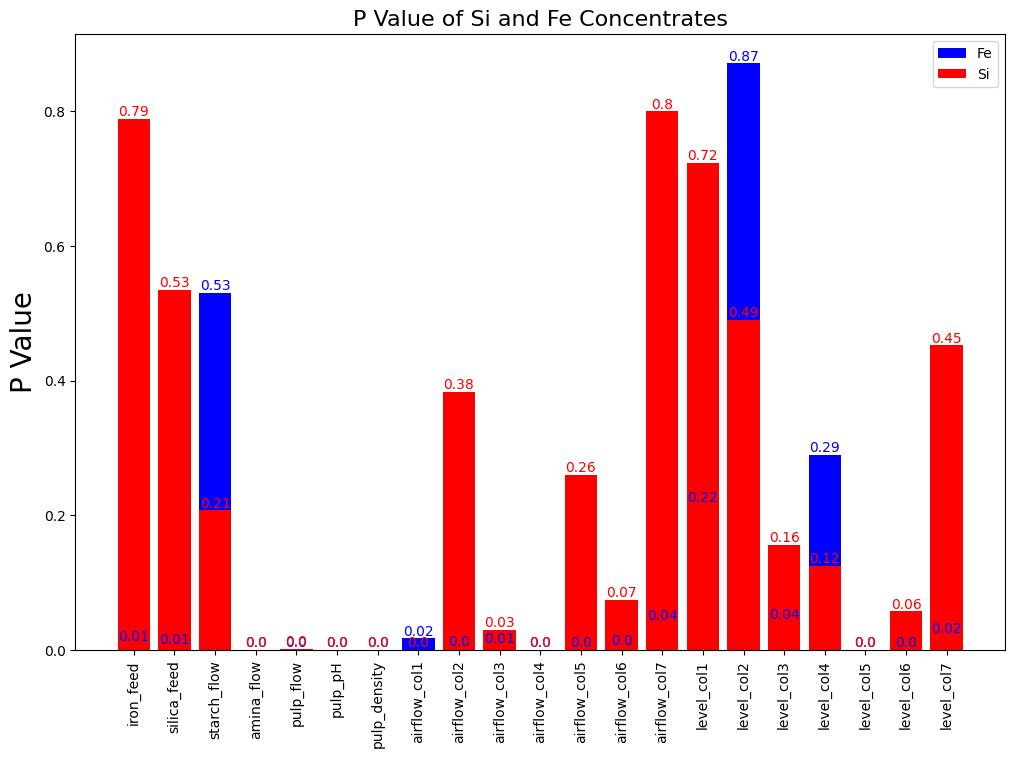

P-values for Fe Concentrate:
iron_feed: 0.01
silica_feed: 0.01
starch_flow: 0.53
amina_flow: 0.0
pulp_flow: 0.0
pulp_pH: 0.0
pulp_density: 0.0
airflow_col1: 0.02
airflow_col2: 0.0
airflow_col3: 0.01
airflow_col4: 0.0
airflow_col5: 0.0
airflow_col6: 0.0
airflow_col7: 0.04
level_col1: 0.22
level_col2: 0.87
level_col3: 0.04
level_col4: 0.29
level_col5: 0.0
level_col6: 0.0
level_col7: 0.02

P-values for Si Concentrate:
iron_feed: 0.79
silica_feed: 0.53
starch_flow: 0.21
amina_flow: 0.0
pulp_flow: 0.0
pulp_pH: 0.0
pulp_density: 0.0
airflow_col1: 0.0
airflow_col2: 0.38
airflow_col3: 0.03
airflow_col4: 0.0
airflow_col5: 0.26
airflow_col6: 0.07
airflow_col7: 0.8
level_col1: 0.72
level_col2: 0.49
level_col3: 0.16
level_col4: 0.12
level_col5: 0.0
level_col6: 0.06
level_col7: 0.45


In [178]:
fe = pValue_fe_list
si = pValue_si_list
t = flotation_conditions.columns

plt.figure(figsize=(12, 8))

plt.bar(t, fe, label='Fe', color='blue')
plt.bar(t, si, label='Si', color='red')
plt.xticks(rotation=90)

plt.legend(loc="upper right", prop={"size": 10})
plt.ylabel('P Value', fontsize=20)
plt.title('P Value of Si and Fe Concentrates', fontsize=16)

for i, value in enumerate(fe):
    plt.text(i, value, f'{round(value, 2)}', 
             ha='center', va='bottom', fontsize=10, color='blue')

for i, value in enumerate(si):
    plt.text(i, value, f'{round(value, 2)}', 
             ha='center', va='bottom', fontsize=10, color='red')

plt.show()

# Text output of p-values
print("P-values for Fe Concentrate:")
for i in range(len(t)):
    print(f"{t[i]}: {round(fe[i], 2)}")

print("\nP-values for Si Concentrate:")
for i in range(len(t)):
    print(f"{t[i]}: {round(si[i], 2)}")


When we examine the P values, we see that some values do not affect the concentrated grades. But now we know that this is due to our lack of data.

### **6.2. Confidence Interval**

- Calculate Confidence Intervals for Iron and Silica Concentrates

In [179]:
m_fe = iron_concentrate.mean()
se_fe = iron_concentrate.std() / math.sqrt(len(iron_concentrate))
ci_fe = [m_fe - se_fe * 1.96, m_fe + se_fe * 1.96]

m_si = silica_concentrate.mean()
se_si = silica_concentrate.std() / math.sqrt(len(silica_concentrate))
ci_si = [m_si - se_si * 1.96, m_si + se_si * 1.96]

print('Confidence interval of Fe Concentrate:', ci_fe)
print('Confidence interval of Silica Concentrate:', ci_si);

Confidence interval of Fe Concentrate: [65.01584910543423, 65.08431621905197]
Confidence interval of Silica Concentrate: [2.2922996415958585, 2.3611745080372653]


Metallurgical engineers apply the pouring process to the concentrate we sell and obtain pure iron. There is a grade range they demand from us for this operation: %67 – 68 Fe Grade %1.6 – 1.7 Si Grade In the model we developed according to the confidence interval, the silica values are more than demanded. In the first stage, we need to warn the engineers in the field. (Assuming our data is reliable.)

## **7. Regression Analysis**


### **7.1. R-squared Analysis**

- Calculate R-squared Values for Iron and Silica Concentrates

In [180]:
model_iron = sm.OLS(endog=iron_concentrate, exog=b_zero).fit()
r_squared_iron = model_iron.rsquared
print("R-squared for Iron Concentrate:", r_squared_iron)

model_silica = sm.OLS(endog=silica_concentrate, exog=b_zero).fit()
r_squared_silica = model_silica.rsquared
print("R-squared for Silica Concentrate:", r_squared_silica);

R-squared for Iron Concentrate: 0.16015805019528695
R-squared for Silica Concentrate: 0.1678571233624352


The R-squared value for the regression model predicting the Iron and Silica Concentrate is approximately 0.16. This means that around 16.02% of the variance in the Iron and Silica Concentrate can be explained by the independent variables included in the model. The remaining 83.98% of the variance is attributed to other factors not accounted for in the model. The model has a relatively low explanatory power for the Iron and Silica Concentrate.

### **7.2. Multiple Linear Analysis**

- Calculate Coefficient and Intercepts Values for Iron and Silica Concentrates

In [181]:
from sklearn.linear_model import LinearRegression

# Create the feature matrix X by selecting the flotation conditions
X = flotation_conditions.values

# Create the target variable y for silica concentrate
y_silica = silica_concentrate

# Create the target variable y for iron concentrate
y_iron = iron_concentrate

# Fit the linear regression model for silica concentrate
model_silica = LinearRegression()
model_silica.fit(X, y_silica)

# Fit the linear regression model for iron concentrate
model_iron = LinearRegression()
model_iron.fit(X, y_iron)

print('Coefficients for Silica Concentrate:', model_silica.coef_)
print('**' * 40)
print('Intercept for Silica Concentrate:', model_silica.intercept_)
print('**' * 40)
print('Coefficients for Iron Concentrate:', model_iron.coef_)
print('**' * 40)
print('Intercept for Iron Concentrate:', model_iron.intercept_)
print('**' * 40);

Coefficients for Silica Concentrate: [-3.69352697e-03  6.44613322e-03 -2.39728162e-04  3.99210408e-03
 -6.99841812e-03 -3.34271470e-01 -2.65145208e+00 -9.66793064e-03
  1.07493605e-03 -4.96241848e-03  4.15185588e-02 -6.26676690e-03
  2.57627964e-03 -4.11050119e-04 -9.55041618e-05 -1.70968519e-04
  2.90417007e-04 -5.73952255e-04 -1.77606936e-03  6.80797400e-04
 -3.47802712e-04]
********************************************************************************
Intercept for Silica Concentrate: 4.529631188444176
********************************************************************************
Coefficients for Iron Concentrate: [ 3.62009460e-02  2.88290141e-02  1.18955922e-04 -4.03632258e-03
  1.57288452e-02  4.64589288e-01  3.52228905e+00  4.88542954e-03
 -3.94517235e-03  6.28982535e-03 -4.93550208e-02  3.01315116e-02
 -4.28433583e-03  3.30332874e-03 -3.33488368e-04 -4.01100754e-05
 -4.15938462e-04  3.95094155e-04  1.87580241e-03 -1.18954669e-03
  1.06054821e-03]
****************************

The intercepts in multiple linear regression represent the expected value of the dependent variable (concentrate) when all the independent variables (flotation conditions) are zero. In this case, we have two separate regression models for silica concentrate and iron concentrate.

For **the silica concentrate model** , the intercept of 4.52963118844632 implies that when all the flotation condition variables are set to zero, the expected value of the silica concentrate is approximately 4.53%. This intercept provides a baseline estimate for the silica concentrate without considering any flotation conditions.

Similarly, for **the iron concentrate model**, the intercept of 51.3164828429035 indicates that when all the flotation condition variables are zero, the expected value of the iron concentrate is approximately 51.32%. This intercept serves as a starting point for the iron concentrate prediction in the absence of any flotation conditions.

It's important to note that in practical scenarios, it is unlikely to have all flotation conditions at exactly zero, and the intercept alone may not provide meaningful information. The coefficients of the regression equation should be considered along with the intercept to fully understand the relationship between the flotation conditions and the concentrate values.

To make accurate predictions or draw meaningful conclusions, it is recommended to use actual values of the flotation conditions rather than relying solely on the intercept.

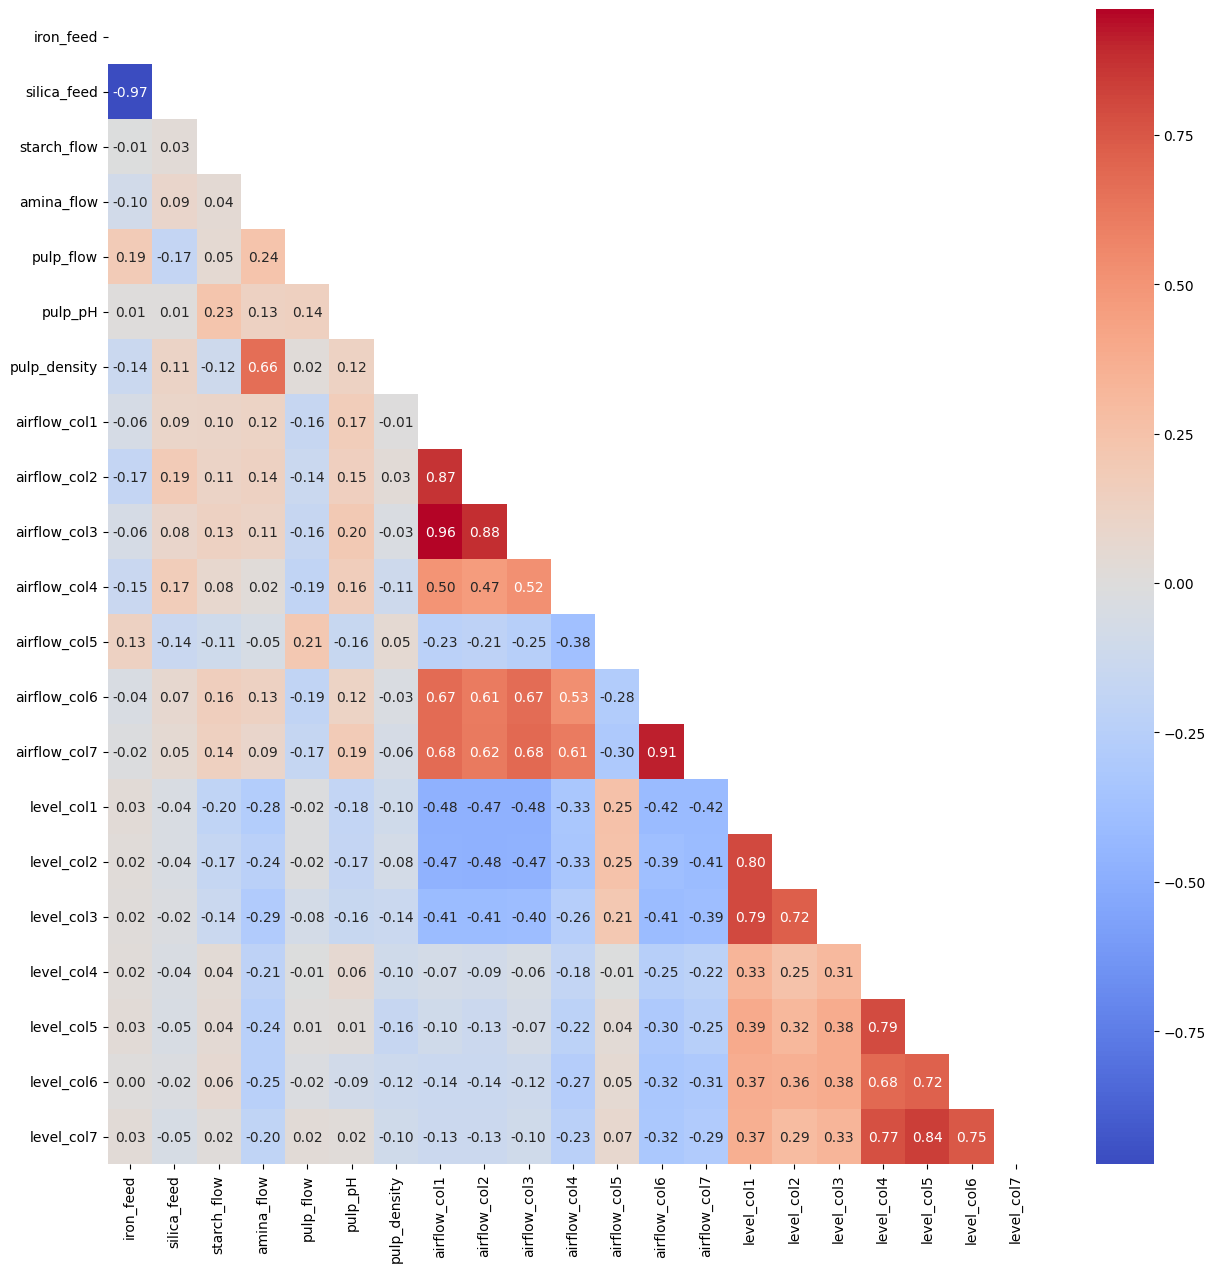

In [182]:
# Compute the correlation matrix
corr_matrix = flotation_conditions.corr()

# Select the features with a correlation above a certain threshold
threshold = 0.5
high_correlation_features = corr_matrix[abs(corr_matrix) > 
                            threshold].stack().dropna().reset_index()
high_correlation_features = high_correlation_features[high_correlation_features['level_0'] != 
                            high_correlation_features['level_1']]
selected_features = set(high_correlation_features['level_0']
                        ).union(set(high_correlation_features['level_1']))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.show();

## **8. Relationship between Dependent and Independent variables**

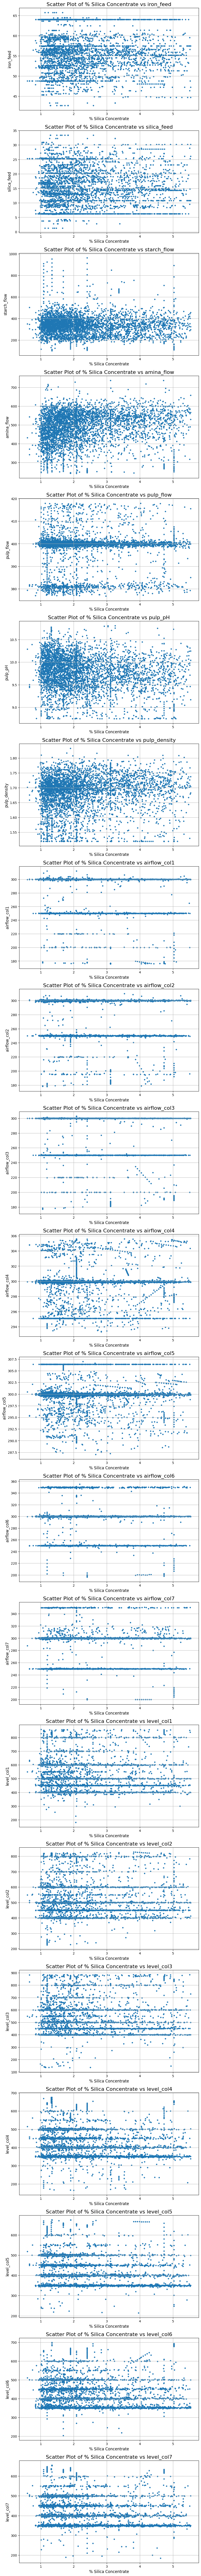

In [183]:
columns = flotation_conditions.columns

num_plots = len(columns)
num_cols = 1
num_rows = (num_plots + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 150))
axes = axes.flatten()

for i, column in enumerate(columns):
    x_axis = silica_concentrate
    y_axis = flotation_conditions[column]
    ax = axes[i]
    ax.scatter(x_axis, y_axis, marker='o', s=10)
    ax.set_xlabel('% Silica Concentrate', fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    ax.set_title(f'Scatter Plot of % Silica Concentrate vs {column}', fontsize=16)
    ax.grid(True)

if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[i])

plt.subplots_adjust(hspace=0.2)
plt.show()

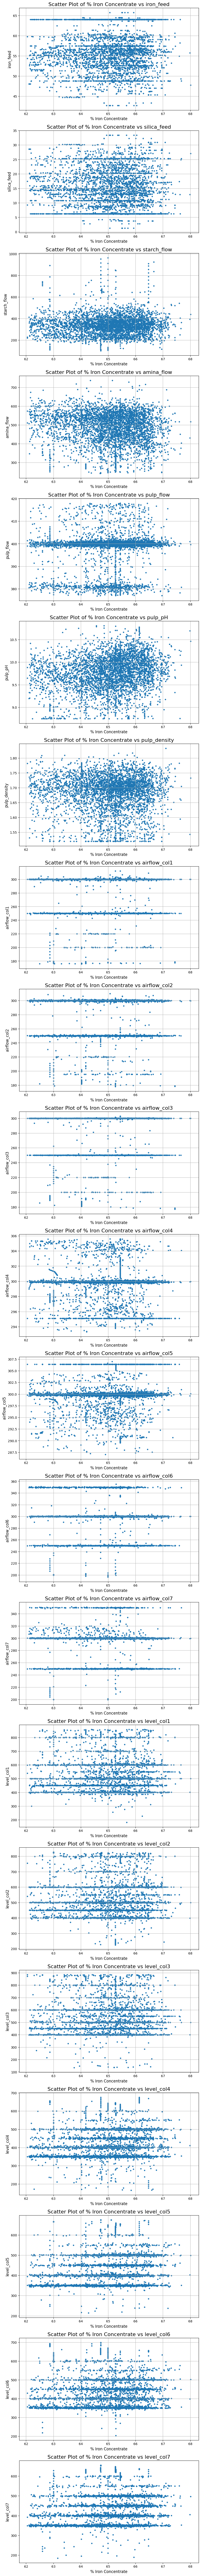

In [184]:
columns = flotation_conditions.columns

num_plots = len(columns)
num_cols = 1
num_rows = (num_plots + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, 
                         figsize=(10, 150))
axes = axes.flatten()

for i, column in enumerate(columns):
    x_axis = iron_concentrate
    y_axis = flotation_conditions[column]
    ax.grid(True)
    ax = axes[i]
    ax.scatter(x_axis, y_axis, marker='o', s=10)
    ax.set_xlabel('% Iron Concentrate', fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    ax.set_title(f'Scatter Plot of % Iron Concentrate vs {column}', 
                 fontsize=16)

if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[i])

plt.subplots_adjust(hspace=0.2)
plt.show()

In [185]:
flotation_conditions.to_csv('/content/drive/My Drive/Flotation/flotation_conditions.csv', index=False)

iron_concentrate = pd.DataFrame({'Iron Concentrate': iron_concentrate})
iron_concentrate.to_csv('/content/drive/My Drive/Flotation/iron_concentrate.csv', index=False)

silica_concentrate = pd.DataFrame({'Silica Concentrate': silica_concentrate})
silica_concentrate.to_csv('/content/drive/My Drive/Flotation/silica_concentrate.csv', index=False)
